http://docs.pymc.io/notebooks/posterior_predictive.html
above is good, but did not end up using it here. 

https://stackoverflow.com/questions/33249122/generating-predictions-from-inferred-parameters-in-pymc3
also did not quite work out.

https://towardsdatascience.com/bayesian-linear-regression-in-python-via-pymc3-ab8c2c498211
vanilla introduction.


In [1]:
# import packages
import pymc3 as pm
import pandas as pd 
import numpy as np 
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import os 
import theano
import theano.tensor as tt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import scale
from scipy import stats

In [2]:

#%%
#victor
# import packages
from covid19dh import covid19
from datetime import date
from Get_covid_data import get_data
import pymc3 as pm
import pandas as pd 
import numpy as np 
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import os 
import theano
import random
# import functions from fns file 
import fns as f

#Get data
data = get_data(level = 2, start = date(2020,1,1)) #can get more or less data here.

data["new_infected"] = data.groupby(["administrative_area_level_2"])["confirmed"].diff()
data = data[data["new_infected"].notna()]

#group_by introduce lag (new infected from commulative)

We have invested a lot of time and effort in creating COVID-19 Data Hub, please cite the following when using it:

	Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.

A BibTeX entry for LaTeX users is

	@Article{,
		title = {COVID-19 Data Hub},
		year = {2020},
		doi = {10.21105/joss.02376},
		author = {Emanuele Guidotti and David Ardia},
		journal = {Journal of Open Source Software},
		volume = {5},
		number = {51},
		pages = {2376},
	}

To hide this message use 'verbose = False'.


## Suggestion for implementing Victor's show in a class

In [45]:
class PyCipio:
    
    def __init__(self, data):
        self.data = data
        
    def make_idx(self, idx, x):
        self.data["idx"] = pd.Categorical(self.data[idx]).codes
        self.data["traincode"] = pd.Categorical(self.data[x]).codes
    
    def train_test_split(self, x, cutoff):
        self.test = self.data[self.data[x] >= cutoff]
        self.train = self.data[self.data[x] < cutoff]
        
    def standardize(self, y):
        self.test["y_stand"] = scale(self.test[y].values)
        self.train["y_stand"] = scale(self.train[y].values)
        
    def get_subset(self, subset_var, subset_val, y):
        # train data
        self.train_sub = self.train[self.train[subset_var] == subset_val]
        self.x_train_sub = self.train_sub.traincode.values # necessary. 
        self.y_train_sub = self.train_sub[y].values

        # test data
        self.test_sub = self.test[self.test[subset_var] == subset_val]
        self.x_test_sub = self.test_sub.traincode.values # necessary. 
        self.y_test_sub = self.test_sub[y].values
        
    def line_plot(self, x, y, hue):
        sns.lineplot(data = self.data, x = x, y = y, hue = hue)
        
    def specify_model(self, n_changepoints = 10, n_components = 3):
        
        #preprocess to make the format work for changepoints
        t = np.arange(len(self.train)) / len(self.train)
        self.s = np.linspace(0, np.max(t), n_changepoints + 2)[1: -1]
        
        self.A = (t[:, None] > self.s) * 1.
        
        #specifying the model
        with pm.Model() as m0:
            
            self.t = theano.shared(self.x_train_sub)#pm.Data('t', self.x_train_sub)
            t = tt.arange(t.shape[0])/t.shape[0]
            
            #priors and trend
            k = pm.Normal("k", 0, 1)
            m = pm.Normal("m", 0, 1)
            
            changepoints_prior_scale = pm.Exponential('tau', 1.5) #0.5 is basically what Facebook Prophet is using
            
            delta = pm.Laplace("delta", 0, changepoints_prior_scale, shape = n_changepoints) #0.5 is tau, which should be given as a hyper
            
            trend = (k + tt.dot(self.A, delta)) * t + (m + tt.dot(self.A, -self.s * delta))
            
            #priors and seasonality:
            
            beta = pm.Normal("beta", 0, 1, shape = n_components * 2)
            
            seasonality = tt.dot(X(t)/365.25, beta) #division to get the yearly component
            
            prediction = trend + seasonality
            
            error = pm.HalfCauchy("error", 1)
            
            #likelihood
            obs = pm.Normal("obs", 
                           mu = prediction,
                           sd = error,
                           observed = self.y_train_sub)
            
            #sample
            self.trace = pm.sample(tune = 500, draws = 500)
            self.prior = pm.sample_prior_predictive()
            self.posterior = pm.sample_posterior_predictive(self.trace)
            
        self.model = m0
        
    def plot_pps(self):
        az.plot_ppc(az.from_pymc3(posterior_predictive=self.prior, model=self.model)) #prior
        az.plot_ppc(az.from_pymc3(posterior_predictive=self.posterior, model=self.model)) #posterior
    
    def plot_trend_season(self):
        p = 0.025
        # vector distributions
        beta_yearly = self.trace['beta']
        delta = self.trace['delta']

        # scalar distributions
        k = self.trace['k']
        m = self.trace['m']

        # determine the posterior by evaulating all the values in the trace.
        trend_posterior = ((k + np.dot(self.A, delta.T)) * self.data['traincode'][:, None] + m + np.dot(self.A, (-self.s * delta).T)) * self.data['confirmed_stand'].max()

        yearly_posterior = det_seasonality_posterior(beta_yearly, x_yearly) * self.data['confirmed_stand'].max()
        #weekly_posterior = det_seasonality_posterior(beta_weekly, x_weekly) * self.data['confirmed_stand'].max()

        date = self.data['date'].dt.to_pydatetime()
        #sunday = np.argmax(df['ds'].dt.dayofweek)
        #weekdays = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
        idx_year = np.argmax(self.data['date'].dt.dayofyear)

        plt.figure(figsize=(16, 3*6))
        b = 411
        plt.subplot(b)
        plt.title('total')
        plt.plot(date,
             (trend_posterior + yearly_posterior).mean(1), lw=0.5)
        plt.scatter(date, df['y'], s=0.5, color='black')

        plt.subplot(b + 1)
        plt.title('trend')
        plt.plot(date, trend_posterior.mean(1))
        quant = np.quantile(trend_posterior, [p, 1 - p], axis=1)
        plt.fill_between(date, quant[0, :], quant[1, :], alpha=0.25)

        plt.subplot(b + 2)
        plt.title('yearly')
        plt.plot(date[idx_year: idx_year + 365], yearly_posterior.mean(1)[idx_year: idx_year + 365])
        quant = np.quantile(yearly_posterior, [p, 1 - p], axis=1)
        plt.fill_between(date[idx_year: idx_year + 365],
                     quant[0, idx_year: idx_year + 365], quant[1, idx_year: idx_year + 365], alpha=0.25)

    def predict(self):
        #x_sharing = np.append(self.x_train_sub, self.x_test_sub)
        with self.model: 
            self.t.set_value(self.x_test_sub)
            m0_pred = pm.sample_posterior_predictive(self.trace, var_names = ["obs"])
        self.pred = m0_pred["obs"]
        
        # plot predictions
        #y_mean = pred.mean(axis=0)
        #y_std = pred.std(axis=0)
        #plt.figure(figsize=(16, 8))
        #plt.scatter(self.x_train_sub, self.y_train_sub, c='k', zorder=10, label='Data')
        #plt.scatter(self.x_test_sub, self.y_test_sub, c="red", label='Held-out')
        #plt.plot(x_test, y_mean, label='Prediction Mean')
        #plt.fill_between(x_test, y_mean - 3*y_std, y_mean + 3*y_std, alpha=0.33, label='Uncertainty Interval ($\mu\pm3\sigma$)')
        #plt.xlabel('$x$')
        #plt.ylabel('$y$')
        #plt.ylim(-14, 16)
        #plt.legend(loc='upper left')
        

In [46]:
### Extremely funky fourier series implementation

def X(t, p = 365.25, n = 3):
    x = 2 * np.pi * (tt.arange(n) + 1) * t[:, None] / p 
    return tt.concatenate((tt.cos(x), tt.sin(x)), axis = 1)

def det_seasonality_posterior(beta, x):
    return np.dot(x, beta.T)

In [47]:
min(data["date"])

Timestamp('2020-01-22 00:00:00')

## CHOPPER DATA!

In [48]:
only_min = data[data["administrative_area_level_2"] == "Minnesota"]

In [49]:
model = PyCipio(only_min)

In [50]:
model.make_idx("administrative_area_level_1", "date")

<ipython-input-45-ad8d9659b5f8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data["idx"] = pd.Categorical(self.data[idx]).codes
<ipython-input-45-ad8d9659b5f8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data["traincode"] = pd.Categorical(self.data[x]).codes


In [51]:
model.train_test_split("date", pd.to_datetime("2021-01-01"))

In [52]:
model.standardize("new_infected")

<ipython-input-45-ad8d9659b5f8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test["y_stand"] = scale(self.test[y].values)
<ipython-input-45-ad8d9659b5f8>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train["y_stand"] = scale(self.train[y].values)


In [53]:
model.get_subset("administrative_area_level_2", "Minnesota", "y_stand")

In [54]:
model.specify_model(n_changepoints=12, n_components=3)

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error, beta, delta, tau, m, k]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 277 seconds.


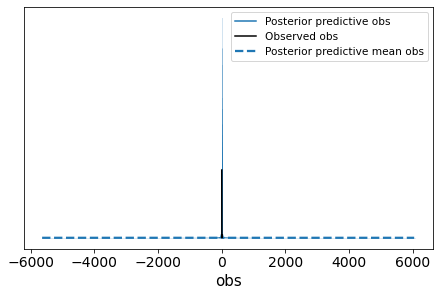

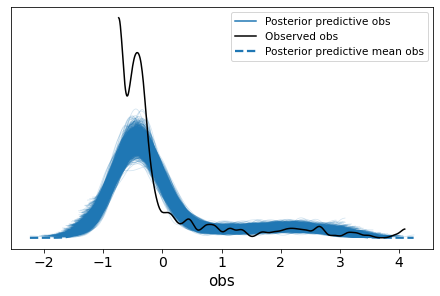

In [37]:
model.plot_pps()

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'k'}>,
        <AxesSubplot:title={'center':'k'}>],
       [<AxesSubplot:title={'center':'m'}>,
        <AxesSubplot:title={'center':'m'}>],
       [<AxesSubplot:title={'center':'delta'}>,
        <AxesSubplot:title={'center':'delta'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>],
       [<AxesSubplot:title={'center':'error'}>,
        <AxesSubplot:title={'center':'error'}>]], dtype=object)

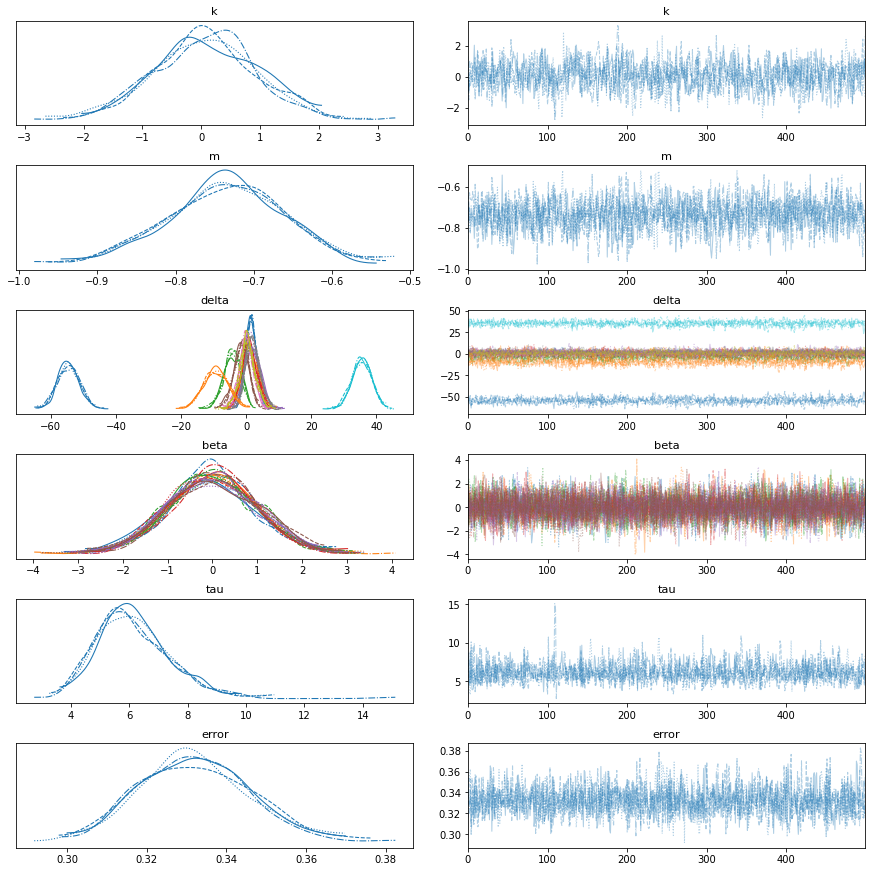

In [38]:
az.plot_trace(model.trace)

In [55]:
model.predict()

In [56]:
predictions = model.pred

In [57]:
predictions.shape

(2000, 300)

In [58]:
model.x_test_sub.shape

(124,)

## Previously working solution

In [242]:
only_min = data[data["administrative_area_level_2"] == "Minnesota"]

In [243]:
only_min["confirmed_stand"] = scale(only_min["confirmed"].values)

<ipython-input-243-f93f792b3848>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_min["confirmed_stand"] = scale(only_min["confirmed"].values)


In [244]:
model = PyCipio(only_min)

In [271]:
model.make_idx("administrative_area_level_1", "date")

TypeError: make_idx() takes 3 positional arguments but 4 were given

In [246]:
model.specify_model(model.data, "confirmed_stand", "traincode", n_changepoints=3)

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error, beta, delta, tau, m, k]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 176 seconds.


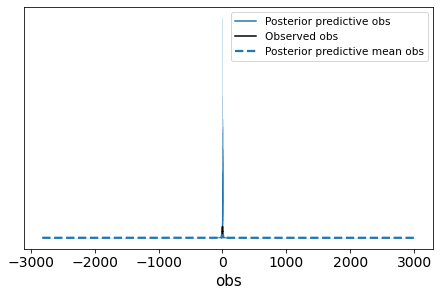

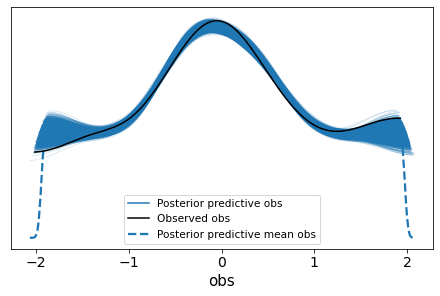

In [247]:
model.plot_pps()

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'k'}>,
        <AxesSubplot:title={'center':'k'}>],
       [<AxesSubplot:title={'center':'m'}>,
        <AxesSubplot:title={'center':'m'}>],
       [<AxesSubplot:title={'center':'delta'}>,
        <AxesSubplot:title={'center':'delta'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>],
       [<AxesSubplot:title={'center':'error'}>,
        <AxesSubplot:title={'center':'error'}>]], dtype=object)

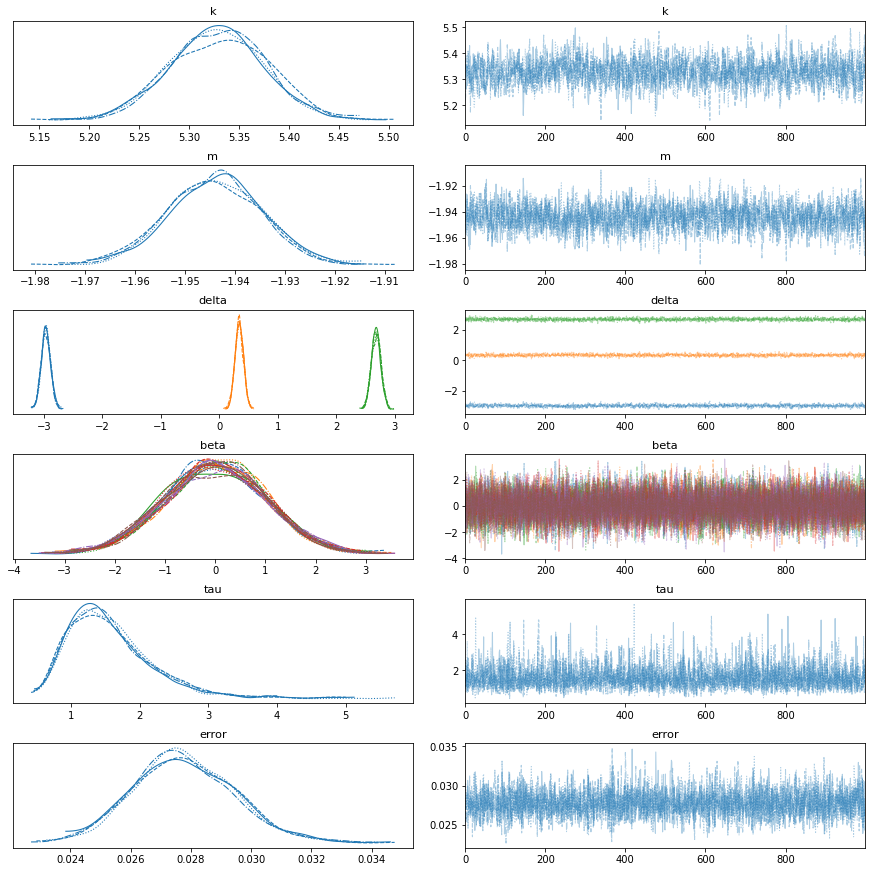

In [248]:
az.plot_trace(model.trace)

In [239]:
model.plot_trend_season()

<ipython-input-230-20847587450e>:87: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  trend_posterior = ((k + np.dot(self.A, delta.T)) * self.data['traincode'][:, None] + m + np.dot(self.A, (-self.s * delta).T)) * self.data['confirmed_stand'].max()


NameError: name 'x_yearly' is not defined

In [34]:
model.data = model.data.set_index("date")

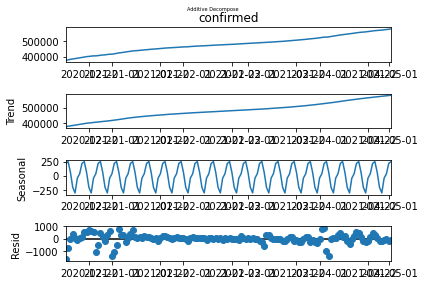

In [20]:
result_add = seasonal_decompose(testing["confirmed"], model='additive', extrapolate_trend='freq')
result_add.plot().suptitle('Additive Decompose', fontsize=5)
plt.show()

In [ ]:
model.data

In [24]:
model = PyCipio(pd.read_csv("../data/hh_budget.csv"))

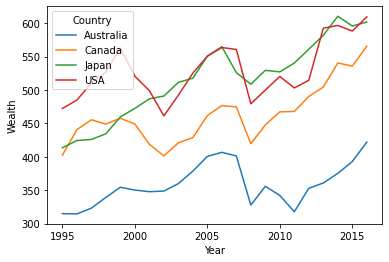

In [25]:
model.line_plot("Year", "Wealth", "Country")

In [26]:
model.make_idx("Country", "Year")

In [27]:
model.train_test_split("Year", 2012)

In [28]:
model.get_subset("Country", "Australia", "Wealth")

In [32]:
testing = model.train_sub.set_index("dt")

In [14]:
data["dt"] = pd.to_datetime(data["Year"], format = "%Y")

In [34]:
result_add = seasonal_decompose(testing["Wealth"], model='additive', extrapolate_trend='freq')

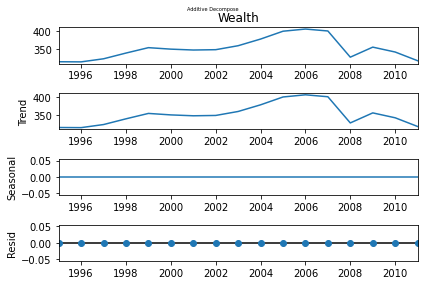

In [39]:
result_add.plot().suptitle('Additive Decompose', fontsize=5)
plt.show()

In [41]:
model.specify_model(model.train_sub, "Wealth")

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error, beta, delta, m, k]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 43 seconds.


C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'k'}>,
        <AxesSubplot:title={'center':'k'}>],
       [<AxesSubplot:title={'center':'m'}>,
        <AxesSubplot:title={'center':'m'}>],
       [<AxesSubplot:title={'center':'delta'}>,
        <AxesSubplot:title={'center':'delta'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'prediction'}>,
        <AxesSubplot:title={'center':'prediction'}>],
       [<AxesSubplot:title={'center':'error'}>,
        <AxesSubplot:title={'center':'error'}>]], dtype=object)

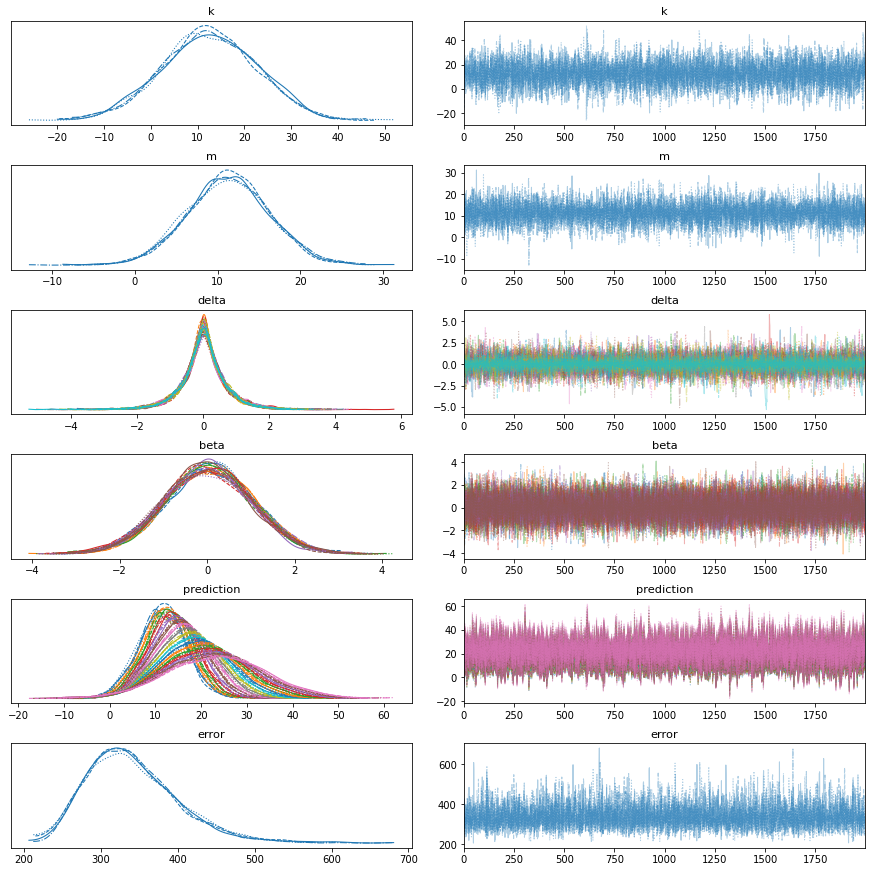

In [42]:
az.plot_trace(model.trace)

## Implementing the framework of Fourier and trend changepoints:

In [181]:
def seasonal_component(X, ω_μ, ω_σ, γ_μ, γ_σ, number = 1):
    # seasonal priors
    ω = pm.Normal(f"ω_{number}", mu = ω_μ, sd = ω_σ)
    γ = pm.Normal(f"γ_{number}", mu = γ_μ, sd = γ_σ)
    
    return ω * theano.tensor.sin(X + γ)
    

In [182]:
# first unpooled (only one country)
with pm.Model() as m0: 
    
    # set priors
    α = pm.Normal('α', mu = 400, sd = 20)
    β = pm.Normal('β', mu = 20, sd = 10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    # seasonal priors
    #ω = pm.Normal("ω", mu = 1, sd = 10)
    #γ = pm.Normal("γ", mu = 1, sd = 10)
    
    Year_ = pm.Data('Year_aust', Year_train_aust) #Year_ as data container (can be changed). 
    
    ## putting it together
    
    y = α + β * Year_
    y += seasonal_component(Year_, 1, 10, 1, 10)
    y += seasonal_component(Year_, 10, 10, 10, 10, 2)
    
    # y pred 
    y_pred = pm.Normal('y_pred', 
                       mu = y, 
                       sd = ϵ, 
                       observed = Wealth_train_aust)
    
    ### EXPERIMENTAL SEASONALITY
    
    # trace 
    m0_trace = pm.sample(2000, return_inferencedata = True)
    m0_prior = pm.sample_prior_predictive(samples=50) # just for model check. 
    m0_ppc = pm.sample_posterior_predictive(m0_trace, 
                                            var_names = ["α", "β", "y_pred"]) # still just for model check.
    #m0_saved = pm.save_trace(m0_trace)

NameError: name 'Year_train_aust' is not defined

In [72]:
# first unpooled (only one country)
with pm.Model() as m0: 
    
    # set priors
    α = pm.Normal('α', mu = 400, sd = 20)
    β = pm.Normal('β', mu = 20, sd = 10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    # seasonal priors
    #ω = pm.Normal("ω", mu = 1, sd = 10)
    #γ = pm.Normal("γ", mu = 1, sd = 10)
    
    Year_ = pm.Data('Year_aust', Year_train_aust) #Year_ as data container (can be changed). 
    
    ## putting it together
    
    y = α + β * Year_
    y += seasonal_component(Year_, 1, 10, 1, 10)
    y += seasonal_component(Year_, 10, 10, 10, 10, 2)
    
    # y pred 
    y_pred = pm.Normal('y_pred', 
                       mu = y, 
                       sd = ϵ, 
                       observed = Wealth_train_aust)
    
    ### EXPERIMENTAL SEASONALITY
    
    # trace 
    m0_trace = pm.sample(2000, return_inferencedata = True)
    m0_prior = pm.sample_prior_predictive(samples=50) # just for model check. 
    m0_ppc = pm.sample_posterior_predictive(m0_trace, 
                                            var_names = ["y_pred"]) # still just for model check.
    #m0_saved = pm.save_trace(m0_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γ_2, ω_2, γ_1, ω_1, ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 68 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.669748092500225, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ω_1'}>,
        <AxesSubplot:title={'center':'ω_1'}>],
       [<AxesSubplot:title={'center':'γ_1'}>,
        <AxesSubplot:title={'center':'γ_1'}>],
       [<AxesSubplot:title={'center':'ω_2'}>,
        <AxesSubplot:title={'center':'ω_2'}>],
       [<AxesSubplot:title={'center':'γ_2'}>,
        <AxesSubplot:title={'center':'γ_2'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

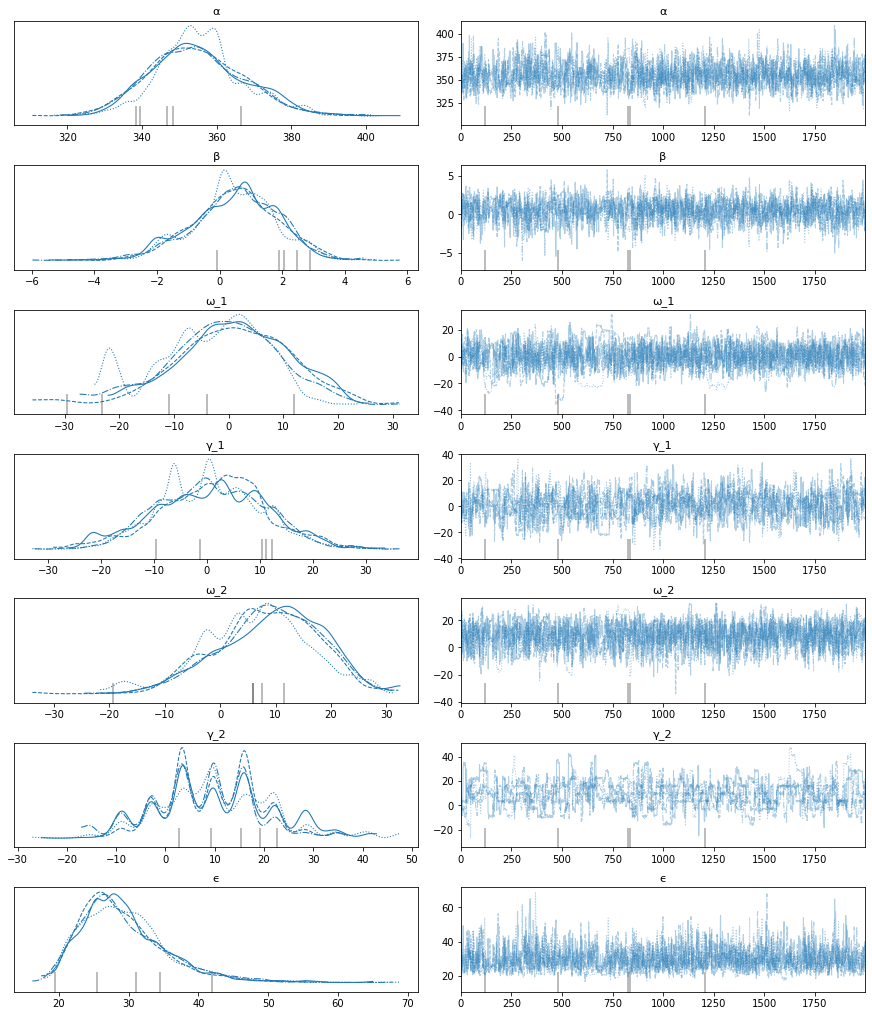

In [73]:
az.plot_trace(m0_trace)

In [77]:
with m0: 
    pm.set_data({'Year_aust': Year_test_aust})
    m0_pred = pm.sample_posterior_predictive(m0_trace, var_names = ["y_pred"])

In [78]:
pred = m0_pred["y_pred"]

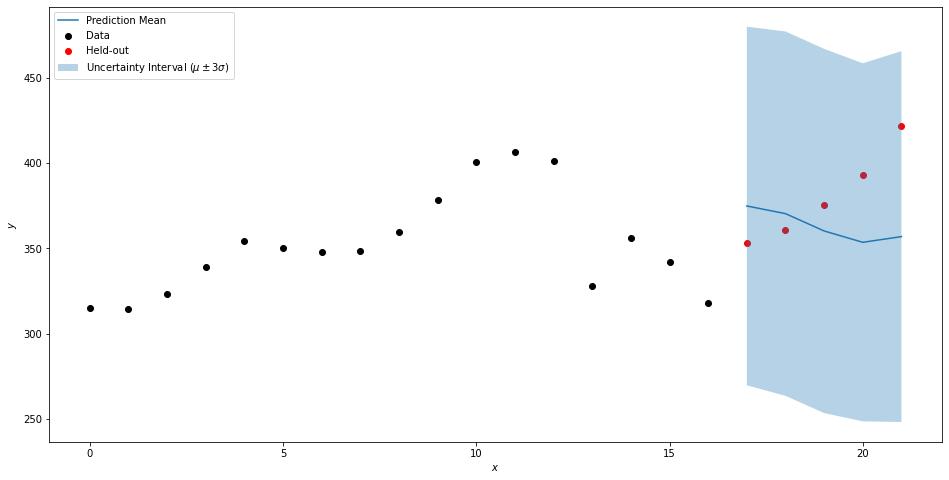

In [79]:
# plot predictions
y_mean = pred.mean(axis=0)
y_std = pred.std(axis=0)
plt.figure(figsize=(16, 8))
plt.scatter(Year_train_aust, Wealth_train_aust, c='k', zorder=10, label='Data')
plt.scatter(Year_test_aust, Wealth_test_aust, c="red", label='Held-out')
plt.plot(Year_test_aust, y_mean, label='Prediction Mean')
plt.fill_between(Year_test_aust, y_mean - 3*y_std, y_mean + 3*y_std, alpha=0.33, label='Uncertainty Interval ($\mu\pm3\sigma$)')
plt.xlabel('$x$')
plt.ylabel('$y$')
#plt.ylim(-14, 16)
plt.legend(loc='upper left')

In [13]:
alpha = np.random.choice(m0_pred["α"], size = 50)
beta = np.random.choice(m0_pred["β"], size = 50)

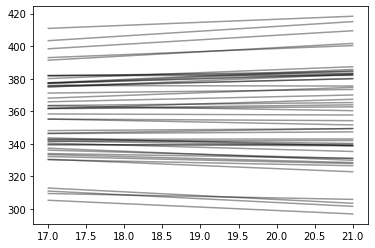

In [14]:
# get predictions as draws instead. 
# should be incorporated in the above function
# https://docs.pymc.io/notebooks/posterior_predictive.html
_, ax = plt.subplots()

for a, b in zip(alpha, beta):
    y = a + b * Year_test_aust
    ax.plot(Year_test_aust, y, c="k", alpha=0.4)
    

In [15]:
# put it together in function
# would be nice to have it as prediction intervals instead of standard deviations. 
def plot_pred(trace, x_train, x_test, y_train, y_test, lines = True, size = 50, std = 3):
    
    ## main part
    pred = trace["y_pred"] # should not be hard-coded of course. 
    pred_mean = pred.mean(axis=0)
    pred_std = pred.std(axis=0)
    plt.figure(figsize=(16, 8))
    plt.scatter(x_train, y_train, c='k', zorder=10, label='Data')
    plt.scatter(x_test, y_test, c="red", label='Held-out')
    plt.plot(x_test, pred_mean, label='Prediction Mean', linewidth = 5, c = "k")
    plt.fill_between(Year_test_aust, pred_mean - std*pred_std, pred_mean + std*pred_std, 
                     alpha=0.2, label='Uncertainty Interval ($\mu\pm3\sigma$)')
    
    ## optionally add lines
    if lines == True: 
        
        alpha = np.random.choice(trace["α"], size = size)
        beta = np.random.choice(trace["β"], size = size)
        
        for a, b in zip(alpha, beta):
            y = a + b * Year_test_aust
            plt.plot(Year_test_aust, y, c="k", alpha=0.4)
    
    ## final stuff
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend(loc='upper left')

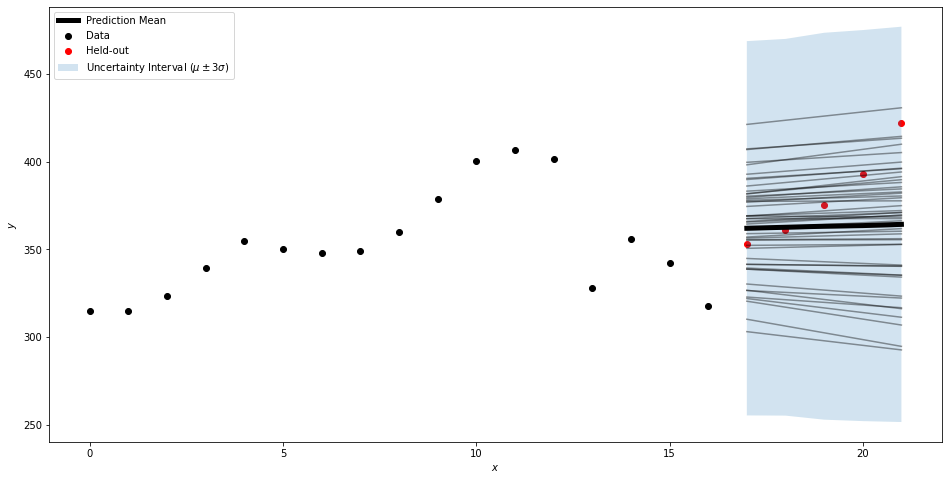

In [16]:
plot_pred(m0_pred, Year_train_aust, Year_test_aust, 
         Wealth_train_aust, Wealth_test_aust)

In [80]:
# Mean square error
y_mean = pred.mean(axis=0) # recall this 

# mean squared error (implement more) 
def MSE_fun(y_true, y_pred): 
    MSE = np.square(np.subtract(y_true, y_pred)).mean() 
    return MSE 

MSE1 = MSE_fun(Wealth_test_aust, y_mean)

In [81]:
# get residuals 
def get_resid(y_true, y_pred): 
    error = [(true - pred) for true, pred in zip(y_true, y_pred)]
    return(error)

res_err = get_resid(Wealth_test_aust, y_mean)

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

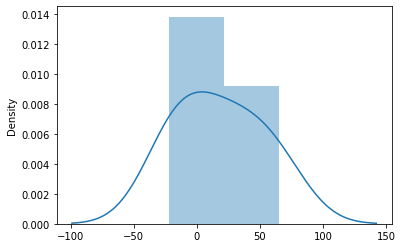

In [82]:
# one way of plotting (distplot)
sns.distplot(res_err)
#plt.hist(res_err)

In [83]:
res_err

[-21.86791773565284,
 -9.616542390049176,
 14.981784346392203,
 39.32013332031704,
 65.05855465404454]

In [84]:
?plt.plot

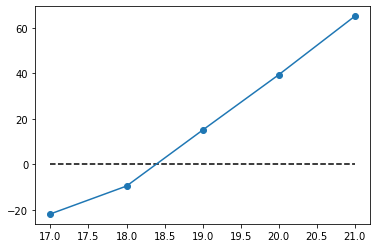

In [85]:
# time residuals (over time). 
plt.scatter(x = Year_test_aust, y = res_err)
plt.plot(Year_test_aust, res_err)
plt.hlines(y = 0, xmin = min(Year_test_aust), xmax = max(Year_test_aust),
          colors = "black", linestyles = "dashed")

In [33]:
# ACF (autocorrelation) of residuals
# pacf (partial) also exists (cool?)
from statsmodels.tsa.stattools import acf
acf_resid = acf(res_err) # perhaps some time-window? (the first will always be 1?)
acf_resid

/home/victormp/miniconda3/envs/bayes/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


array([ 1.        ,  0.36006367, -0.10577288, -0.38123692, -0.37305387])

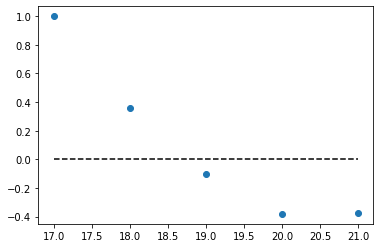

In [45]:
# plot
plt.scatter(x = Year_test_aust, y = acf_resid)
plt.hlines(y = 0, xmin = min(Year_test_aust), xmax = max(Year_test_aust),
          colors = "black", linestyles = "dashed")

(array([0.02996682, 0.01498341, 0.01498341, 0.        , 0.01498341]),
 array([-8.9516633,  4.3964324, 17.7445281, 31.0926238, 44.4407195,
        57.7888152]),
 <BarContainer object of 5 artists>)

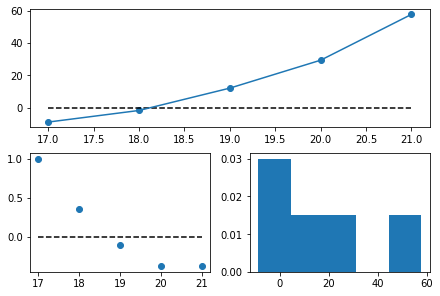

In [96]:
# plot them together (lige gg_tsresiduals)
# https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html
# https://matplotlib.org/stable/tutorials/intermediate/gridspec.html
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
f_ax1 = fig.add_subplot(spec[0, 0:]) # the whole upper. 
f_ax2 = fig.add_subplot(spec[1, 0])
f_ax3 = fig.add_subplot(spec[1, 1])

# first plot
f_ax1.scatter(x = Year_test_aust, y = res_err)
f_ax1.plot(Year_test_aust, res_err)
f_ax1.hlines(y = 0, xmin = min(Year_test_aust), xmax = max(Year_test_aust),
             colors = "black", linestyles = "dashed")

# second plot --> needs correction
f_ax2.scatter(x = Year_test_aust, y = acf_resid)
f_ax2.hlines(y = 0, xmin = min(Year_test_aust), xmax = max(Year_test_aust),
             colors = "black", linestyles = "dashed")

# third plot
f_ax3.hist(res_err, bins = len(res_err))


In [127]:
# four plots instead (should be more straight forward)
# make this flexible and nice. 
def res_plot(trace, x_train, x_test, y_train, y_test, lines = True, size = 50, std = 3):
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))

    # first plot
    ## main part
    pred = trace["y_pred"] # should not be hard-coded of course. 
    pred_mean = pred.mean(axis=0)
    pred_std = pred.std(axis=0)
    axes[0, 0].scatter(x_train, y_train, c='k', zorder=10, label='Data')
    axes[0, 0].scatter(x_test, y_test, c="red", label='Held-out')
    axes[0, 0].plot(x_test, pred_mean, label='Prediction Mean', linewidth = 5, c = "k")
    axes[0, 0].fill_between(Year_test_aust, pred_mean - std*pred_std, pred_mean + std*pred_std, 
                     alpha=0.2, label='Uncertainty Interval ($\mu\pm3\sigma$)')

    ## optionally add lines
    if lines == True: 

        alpha = np.random.choice(trace["α"], size = size)
        beta = np.random.choice(trace["β"], size = size)

        for a, b in zip(alpha, beta):
            y = a + b * Year_test_aust
            axes[0, 0].plot(Year_test_aust, y, c="k", alpha=0.4)
    
    axes[0, 0].set_xlabel("x")
    axes[0, 0].set_ylabel("y")
    
    # second plot
    axes[0, 1].scatter(x = Year_test_aust, y = res_err)
    axes[0, 1].plot(Year_test_aust, res_err)
    axes[0, 1].hlines(y = 0, xmin = min(Year_test_aust), xmax = max(Year_test_aust),
                      colors = "black", linestyles = "dashed")
    
    axes[0, 1].set_xlabel("time unit")
    axes[0, 1].set_ylabel("residuals")
    
    # third plot
    axes[1, 0].scatter(x = Year_test_aust, y = acf_resid)
    axes[1, 0].hlines(y = 0, xmin = min(Year_test_aust), xmax = max(Year_test_aust),
                      colors = "black", linestyles = "dashed")
    
    axes[1, 0].set_xlabel("lag[1]") # should be flexible (and we should be sure that it is lag = 1)
    axes[1, 0].set_ylabel("ACF")

    # fourth plot
    sns.distplot(res_err, ax = axes[1, 1]) # setting bins?

/home/victormp/.local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


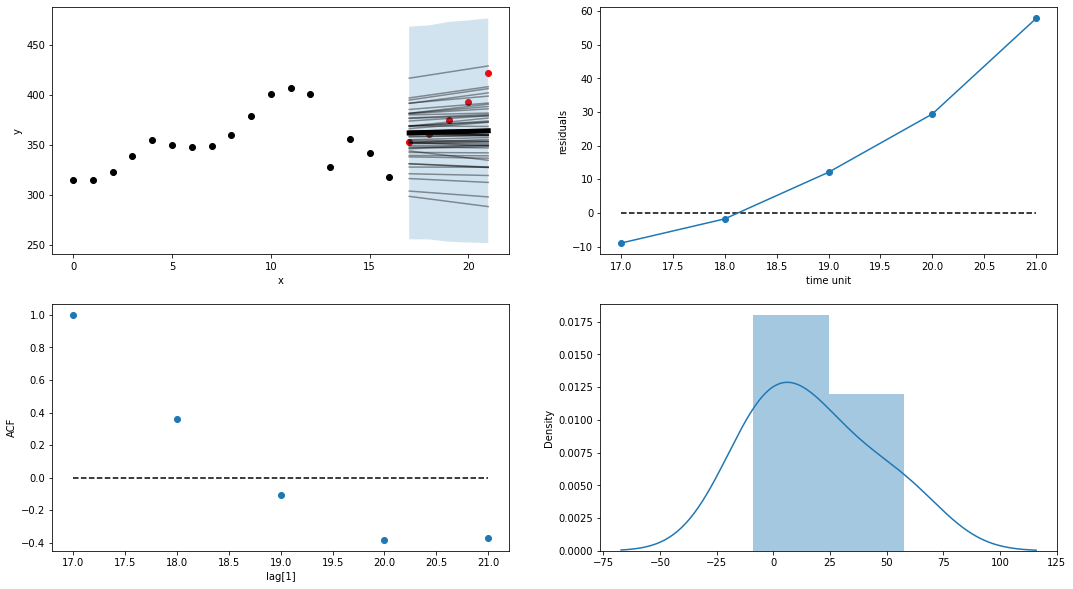

In [128]:
res_plot(m0_pred, Year_train_aust, Year_test_aust, 
         Wealth_train_aust, Wealth_test_aust)

In [ ]:
## now all countries
# train data
idx_train = train.idx.values
Year_train = train.traincode.values # necessary. 
Wealth_train = train.Wealth.values

# test data
idx_test = test.idx.values
Year_test = test.traincode.values
Wealth_test = test.Wealth.values

### Completely new attempt

In [3]:
def det_dot(a, b):
    """
    The theano dot product and NUTS sampler don't work with large matrices?
    
    :param a: (np matrix)
    :param b: (theano vector)
    """
    return (a * b[None, :]).sum(axis=-1)



In [133]:
df = data

In [4]:
df = data[data["administrative_area_level_2"] == "Minnesota"]

In [5]:
df.reset_index(inplace = True)

<ipython-input-6-ec0e2f1a2174>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
<ipython-input-6-ec0e2f1a2174>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y_scaled'] = df['new_infected'] / df['new_infected'].max()
<ipython-input-6-ec0e2f1a2174>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

<AxesSubplot:title={'center':"Wikipedia pageviews for 'Peyton Manning'"}, xlabel='date'>

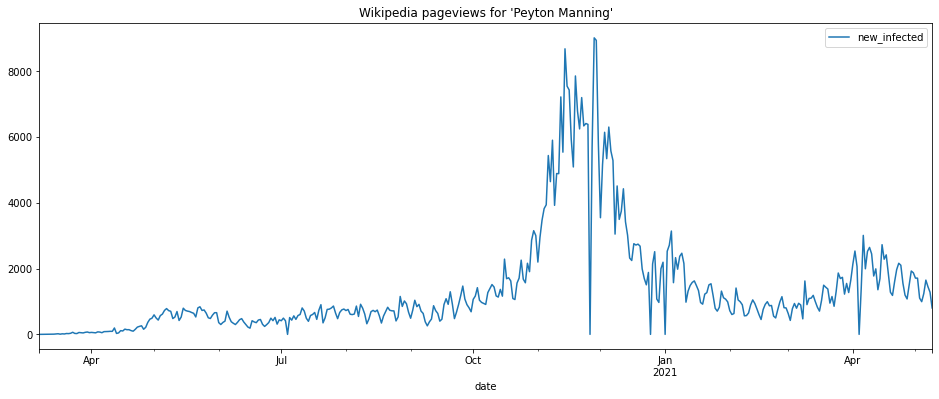

In [6]:
df['date'] = pd.to_datetime(df['date'])
# Scale the data
df['y_scaled'] = df['new_infected'] / df['new_infected'].max()
df['t'] = (df['date'] - df['date'].min()) / (df['date'].max() - df['date'].min())
df.reset_index()
df.plot(x='date', y='new_infected', figsize=(16, 6), title="Wikipedia pageviews for 'Peyton Manning'")

In [16]:
def trend_model(m, t, n_changepoints=25, changepoints_prior_scale=0.05, 
                growth_prior_scale=5, changepoint_range=0.8):
    """
    The piecewise linear trend with changepoint implementation in PyMC3.
    :param m: (pm.Model)
    :param t: (np.array) MinMax scaled time.
    :param n_changepoints: (int) The number of changepoints to model.
    :param changepoint_prior_scale: (flt/ None) The scale of the Laplace prior on the delta vector.
                                    If None, a hierarchical prior is set.
    :param growth_prior_scale: (flt) The standard deviation of the prior on the growth.
    :param changepoint_range: (flt) Proportion of history in which trend changepoints will be estimated. 
    :return g, A, s: (tt.vector, np.array, tt.vector)
    """
    s = np.linspace(0, changepoint_range * np.max(t), n_changepoints + 1)[1:]
    
    # * 1 casts the boolean to integers
    A = (t[:, None] > s) * 1

    with m:
        # initial growth
        k = pm.Normal('k', 0 , growth_prior_scale)
        
        if changepoints_prior_scale is None:
            changepoints_prior_scale = pm.Exponential('tau', 1.5)
        
        # rate of change
        delta = pm.Laplace('delta', 0, changepoints_prior_scale, shape=n_changepoints)
        # offset
        m = pm.Normal('m', 0, 5)
        gamma = -s * delta
        
        g = (k + det_dot(A, delta)) * t + (m + det_dot(A, gamma))
    return g, A, s

# Generate a PyMC3 Model context
m = pm.Model()

with m:
    y, A, s = trend_model(m, df['t'], n_changepoints = 60, changepoints_prior_scale = 0.5)
    
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
    pm.Normal('obs', 
                 mu=y,
                 sd=sigma,
                 observed=df['y_scaled'])

<ipython-input-16-13ae11b217ef>:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  A = (t[:, None] > s) * 1


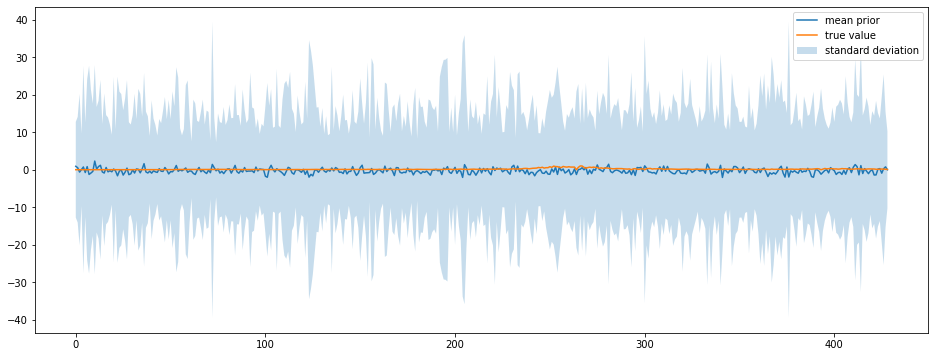

In [17]:
def sanity_check(m, df):
    """
    :param m: (pm.Model)
    :param df: (pd.DataFrame)
    """
    # Sample from the prior and check of the model is well defined.
    y = pm.sample_prior_predictive(model=m, var_names=['obs'])['obs']
    plt.figure(figsize=(16, 6))
    plt.plot(y.mean(0), label='mean prior')
    plt.fill_between(np.arange(y.shape[1]), -y.std(0), y.std(0), alpha=0.25, label='standard deviation')
    plt.plot(df['y_scaled'], label='true value')
    plt.legend()

# And run the sanity check
sanity_check(m, df)

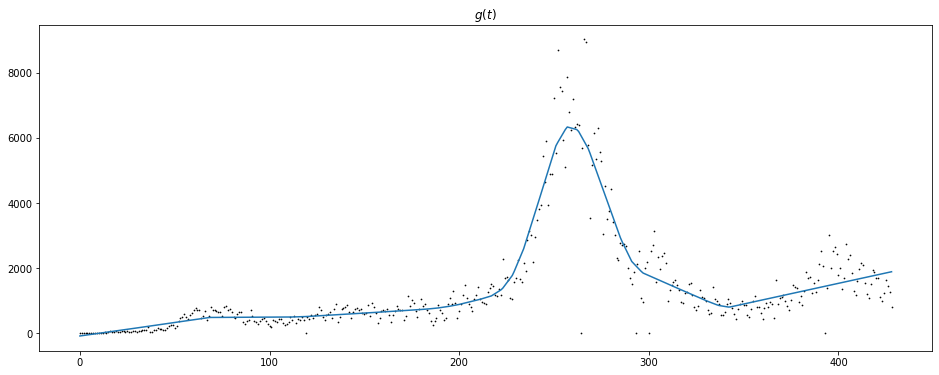

In [18]:
# Find a point estimate of the models parameters
with m:
    aprox = pm.find_MAP()

# Determine g, based on the parameters
def det_trend(k, m, delta, t, s, A):
    return (k + np.dot(A, delta)) * t + (m + np.dot(A, (-s * delta)))

# run function and rescale to original scale
g = det_trend(aprox['k'], aprox['m'], aprox['delta'], df['t'], s, A) * df['new_infected'].max()

plt.figure(figsize=(16, 6))
plt.title('$g(t)$')
plt.plot(g)
plt.scatter(np.arange(df.shape[0]), df.new_infected, s=0.5, color='black')

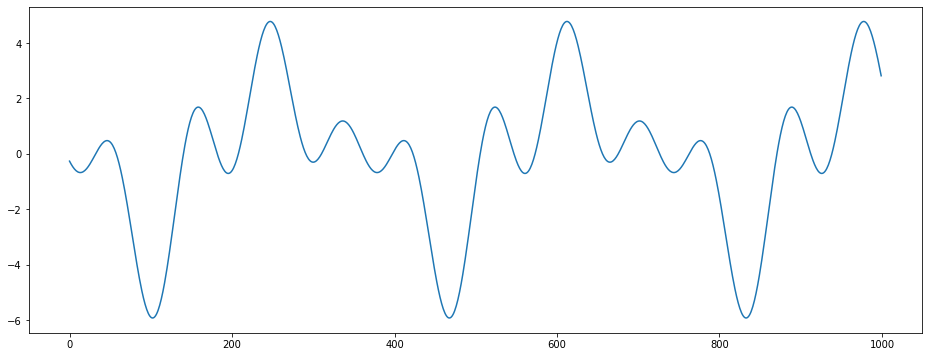

In [19]:
np.random.seed(6)
def fourier_series(t, p=365.25, n=10):
    # 2 pi n / p
    x = 2 * np.pi * np.arange(1, n + 1) / p
    # 2 pi n / p * t
    x = x * t[:, None]
    x = np.concatenate((np.cos(x), np.sin(x)), axis=1)
    return x

n = 4
t = np.arange(1000)
beta = np.random.normal(size=2 * n)
plt.figure(figsize=(16, 6))
plt.plot(fourier_series(t, 365.25, n) @ beta)

In [21]:
def seasonality_model(m, df, period='yearly', seasonality_prior_scale=10):
    
    if period == 'yearly':
        n = 10
        # rescale the period, as t is also scaled
        p = 365.25 / (df['date'].max() - df['date'].min()).days
        
    if period == "monthly":
        n = 10
        # rescale the period, as t is also scaled
        p = 30.5 / (df['date'].max() - df['date'].min()).days
    else:  # weekly
        n = 3
        # rescale the period, as t is also scaled
        p = 7 / (df['date'].max() - df['date'].min()).days
    x = fourier_series(df['t'], p, n)
    with m:
        beta = pm.Normal(f'beta_{period}', mu=0, sd=seasonality_prior_scale, shape=2 * n)
    return x, beta

m = pm.Model()

with m:
    # changepoints_prior_scale is None, so the exponential distribution
    # will be used as prior on \tau.
    y, A, s = trend_model(m, df['t'], changepoints_prior_scale=None, n_changepoints = 40)
    #x_yearly, beta_yearly = seasonality_model(m, df, 'yearly')
    x_monthly, beta_monthly = seasonality_model(m, df, "monthly")
    x_weekly, beta_weekly = seasonality_model(m, df, 'weekly')
    
    y += det_dot(x_weekly, beta_weekly) + det_dot(x_monthly, beta_monthly) # + det_dot(x_yearly, beta_yearly)
    
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
    obs = pm.Normal('obs', 
                 mu=y, 
                 sd=sigma,
                 observed=df['y_scaled'])

<ipython-input-16-13ae11b217ef>:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  A = (t[:, None] > s) * 1
<ipython-input-19-b1e1b4164f23>:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x * t[:, None]


C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_weekly, beta_monthly, m, delta, tau, k]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 833 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `fro

array([[<AxesSubplot:title={'center':'k'}>,
        <AxesSubplot:title={'center':'k'}>],
       [<AxesSubplot:title={'center':'delta'}>,
        <AxesSubplot:title={'center':'delta'}>],
       [<AxesSubplot:title={'center':'m'}>,
        <AxesSubplot:title={'center':'m'}>],
       [<AxesSubplot:title={'center':'beta_monthly'}>,
        <AxesSubplot:title={'center':'beta_monthly'}>],
       [<AxesSubplot:title={'center':'beta_weekly'}>,
        <AxesSubplot:title={'center':'beta_weekly'}>],
       [<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

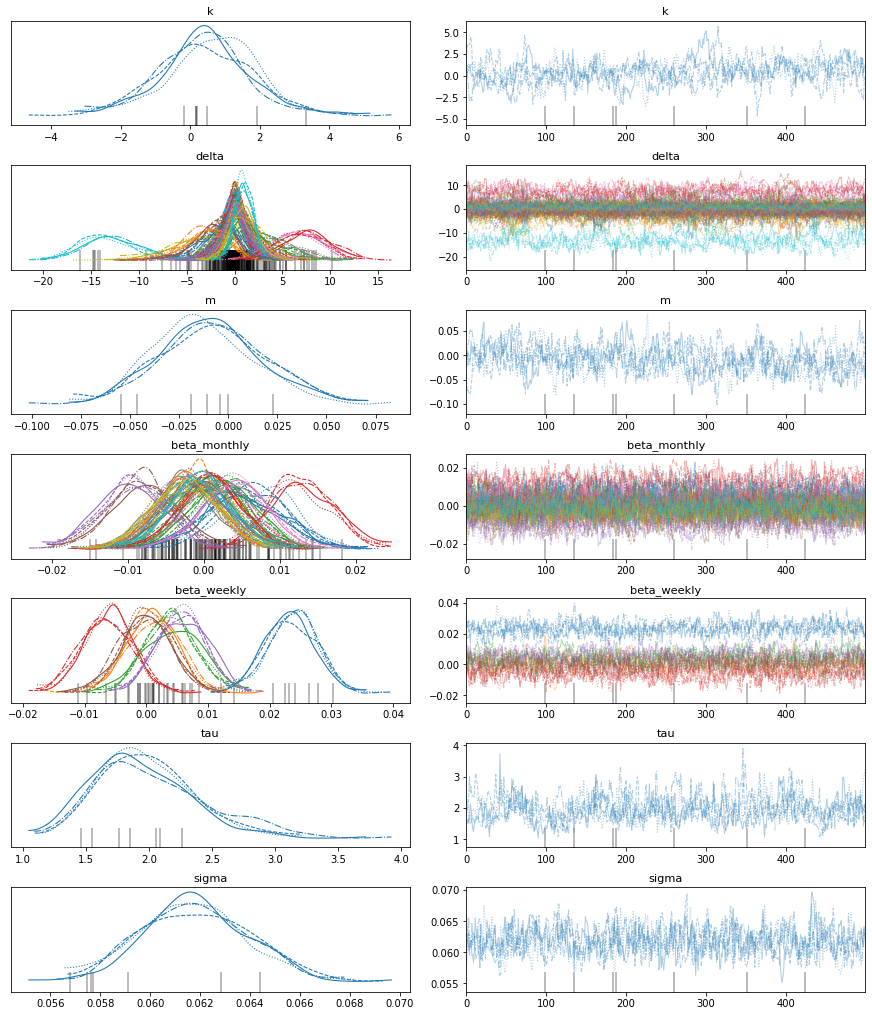

In [22]:
with m:
    trace = pm.sample(500)
az.plot_trace(trace)

<ipython-input-28-6f0359aa9ec0>:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  trend_posterior = ((k + np.dot(A, delta.T)) * df['t'][:, None] + m + np.dot(A, (-s * delta).T)) * df['new_infected'].max()


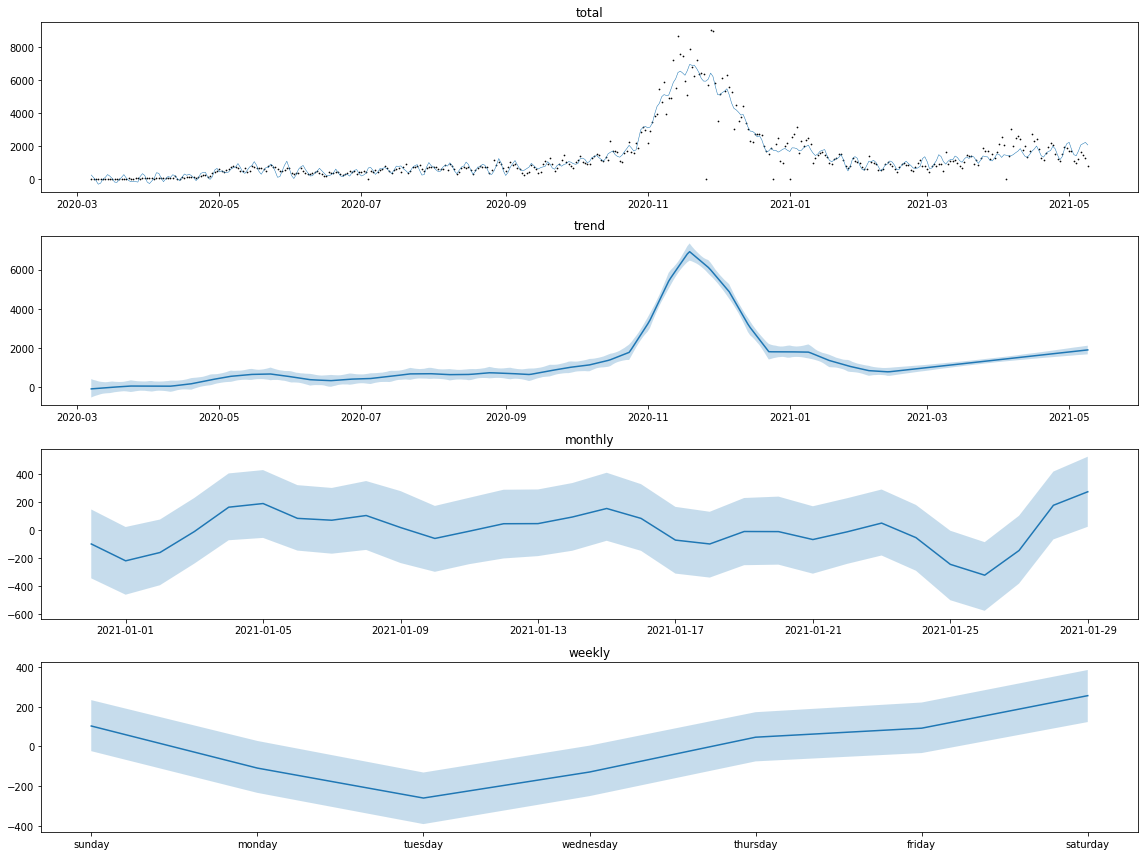

In [28]:
def det_seasonality_posterior(beta, x):
    return np.dot(x, beta.T)

p = 0.025
# vector distributions
#beta_yearly = trace['beta_yearly']
beta_monthly = trace["beta_monthly"]
beta_weekly = trace['beta_weekly']
delta = trace['delta']

# scalar distributions
k = trace['k']
m = trace['m']

# determine the posterior by evaulating all the values in the trace.
trend_posterior = ((k + np.dot(A, delta.T)) * df['t'][:, None] + m + np.dot(A, (-s * delta).T)) * df['new_infected'].max()

#yearly_posterior = det_seasonality_posterior(beta_yearly, x_yearly) * df['new_infected'].max()
monthly_posterior = det_seasonality_posterior(beta_monthly, x_monthly) * df["new_infected"].max()
weekly_posterior = det_seasonality_posterior(beta_weekly, x_weekly) * df['new_infected'].max()

date = df['date'].dt.to_pydatetime()
sunday = np.argmax(df['date'].dt.dayofweek)
weekdays = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
idx_year = np.argmax(df['date'].dt.dayofyear)

fig, axes = plt.subplots(4,1, figsize = (16,12))

#plt.figure(figsize=(16, 3*6))
#b = 411
#plt.subplot(b)
axes[0].set(title = 'total')
axes[0].plot(date,
         (trend_posterior + monthly_posterior + weekly_posterior).mean(1), lw=0.5)
axes[0].scatter(date, df['new_infected'], s=0.5, color='black')

#plt.subplot(b + 1)
axes[1].set_title('trend')
axes[1].plot(date, trend_posterior.mean(1))
quant = np.quantile(trend_posterior, [p, 1 - p], axis=1)
axes[1].fill_between(date, quant[0, :], quant[1, :], alpha=0.25)

#plt.subplot(b + 2)
#axes[2].set_title('yearly')
#axes[2].plot(date[idx_year: idx_year + 365], yearly_posterior.mean(1)[idx_year: idx_year + 365])
#quant = np.quantile(yearly_posterior, [p, 1 - p], axis=1)
#axes[2].fill_between(date[idx_year: idx_year + 365],
                 #quant[0, idx_year: idx_year + 365], quant[1, idx_year: idx_year + 365], alpha=0.25)

#plt.subplot(b + 3)
axes[2].set_title('monthly')
axes[2].plot(date[idx_year: idx_year + 30], monthly_posterior.mean(1)[idx_year: idx_year + 30])
quant = np.quantile(monthly_posterior, [p, 1 - p], axis=1)
axes[2].fill_between(date[idx_year: idx_year + 30],
                 quant[0, idx_year: idx_year + 30], quant[1, idx_year: idx_year + 30], alpha=0.25)

#plt.subplot(b + 4)
axes[3].set_title('weekly')
axes[3].plot(weekdays, weekly_posterior.mean(1)[sunday: sunday + 7])
quant = np.quantile(weekly_posterior, [p, 1 - p], axis=1)
axes[3].fill_between(weekdays, quant[0, sunday: sunday + 7],
                 quant[1, sunday: sunday + 7], alpha=0.25)

fig.tight_layout()

<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexin

<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexin

<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexin

<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexin

<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexin

<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexin

<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexin

<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexin

<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexin

<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexin

<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexin

<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexin

<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexin

<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexin

<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexin

<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_A = (future['t'][:, None] > new_s) * 1
<ipython-input-108-2f9da43ba798>:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexin

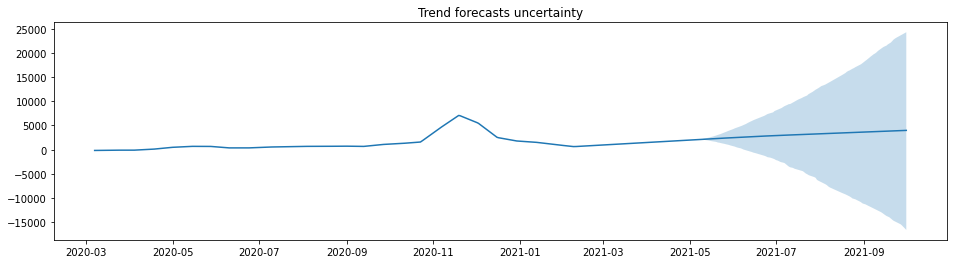

In [108]:
n_samples = 1000
n_changepoints = 10
days = 150
history_points = df.shape[0]
probability_changepoint = n_changepoints / history_points

future = pd.DataFrame({'date': pd.date_range(df['date'].min(), 
                                           df['date'].max() + pd.Timedelta(days, 'D'), 
                        df.shape[0] + days)})
future['t'] = (future['date'] - df['date'].min()) / (df['date'].max() - df['date'].min())

# vector distributions
beta_yearly = trace['beta_yearly'].mean(0)
beta_weekly = trace['beta_weekly'].mean(0)
delta = trace['delta'].mean(0)

# scalar distributions
k = trace['k'].mean()
m = trace['m'].mean()

trend_forecast = []
lambda_ = trace['tau'].mean()

for n in range(n_samples):
    new_changepoints = future['t'][future['t'] > 1].values
    sample = np.random.random(new_changepoints.shape)
    new_changepoints = new_changepoints[sample <= probability_changepoint]
    new_delta = np.r_[delta, 
                      stats.laplace(0, lambda_).rvs(new_changepoints.shape[0])]
    new_s = np.r_[s, new_changepoints]
    new_A = (future['t'][:, None] > new_s) * 1

    trend_forecast.append(((k + np.dot(new_A, new_delta)) * future['t']  + (m + np.dot(new_A, (-new_s * new_delta)))) * df['new_infected'].max())
    
trend_forecast = np.array(trend_forecast)

date = future['date'].dt.to_pydatetime()
plt.figure(figsize=(16, 4))
plt.title('Trend forecasts uncertainty')
plt.plot(date, trend_forecast.mean(0))
quant = np.quantile(trend_forecast, [0.025, 0.975], axis=0)
plt.fill_between(date, quant[0, :], quant[1, :], alpha=0.25)